# Project 2 -- All 5 Categories

In [3]:
from ultralytics import YOLO
from roboflow import Roboflow
import os
import matplotlib.pyplot as plt
from PIL import Image
from shuffle import train_test_split
import pydoc
import cv2

In [4]:

def path_to(*p):
    """
    Takes an arbitrary number of strings and converts it to a path
    with the current working directory automatically tacked onto the front of the path.
    
    Parameters:
        *p (str): Single string or list of strings.
    
    Returns:
        (string): Full path to desired directory/file
    """
    return os.path.join(os.getcwd(), *p)

## Download dataset form Roboflow
For this to work you must update with your own API key. This is only necessary if you want to train it yourself.

In [5]:
def download_dataset(v: int):
    """
    Function that takes the dataset version and downloads if from our Roboflow Project.
    The dataset will be save under project2-dataset-{v}.
    
    Parameters:
        v (int): the version number of the dataset that you want to download
    Returns: 
        None: This function does not return anything.
        
    """
    rf = Roboflow(api_key="jSHmBYOVLG3O81wzzHz3")
    project = rf.workspace("pikavision").project("project2-dataset")
    version = project.version(v)
    dataset = version.download("yolov11")
download_dataset(3)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to project2-dataset-3 in yolov11:: 100%|██████████| 19466/19466 [00:01<00:00, 18646.78it/s]


### Split the data
This splits the data into train, valid, and test datasets at random. 

85% train, 10% validation, 5% test

In [6]:
# Split data into train validation and dest datasets
train_test_split(path_to('project2-dataset-3', 'train'), percentage_test=5, percentage_valid=10)

Total images in src directory: 9730
pikachu_00407_jpg.rf.b9ecffde1cd9923c545aa9671835ccb9
Siamese_128_jpg.rf.82c8ffa0df1ad93922c2eed1f4bc2940
image-461-_jpg.rf.3d39e6b2bcaa3f480a9970bbe1f36330
Persian_196_jpg.rf.8fd0fdd0695ce403e572e23b29f935cd
pikachu_00405_jpg.rf.e2ad759ff30eb40b190b82ae4384f126
leonberger_103_jpg.rf.fc4719846c3c9aec25088b6a1911db4e
1-219-_jpeg_jpg.rf.73a4f52f404e1aa842d5b7216b751d0c
chihuahua_125_jpg.rf.7c643c0da39dbd5116126af98ddcd337
pic_500_jpg.rf.60672d00e72d2d95dd5acce23891998d
image-185-_jpg.rf.6ca54b361133f435f5a316f1fff17deb
image-243-_jpg.rf.0f34653d90f5ef75b545fbcaebcb3038
drone_1_91_jpeg_jpg.rf.423ca72e6476d0ebfbfea05c67b205fb
pug_108_jpg.rf.9ec39711cdeb0a85ef9f32f4d6786b10
Egyptian_Mau_143_jpg.rf.f5a0ca4e0160e19725e1b2ac1ff76e83
Persian_175_jpg.rf.45380003fb370150cd4b6b8da6f686f9
image-703-_jpg.rf.9a7d7fc222e1b6a81cbe000d096d576e
image-509-_jpg.rf.52039cc92c5ede7c491532c687b25963
yoto02727_jpg.rf.af4a5661e12b6e09d86e6e0635872a57
tello_131_jpeg_jpg.rf.abd

## Test Model Function

Takes the model and a sample image and saves new photo with prediction(s) and bounding boxes.

In [7]:
def test_model(model : YOLO, sample_image : str):
    """
    Takes the model and a sample image and then produces a prediction image.
    The function saves the image to the test_images folder.
    It also shows the predictions using matplotlib.
    
    Parameters:
        model (YOLO): YOLO model that you want to make a prediction with.
        sample_image (str): Sample image to make the prediction on. Can by .png or .jpg
    
    Returns:
        None: This function does not return any value.

    """
    path_to_img = path_to('test_images', sample_image)
    results = model.predict(
        source=path_to_img,
        conf=0.1,
    )

    for r in results:
        name = 'the_detected_' + sample_image
        path_to_predicted_img = path_to('test_images', name)
        r.save(path_to_predicted_img)
    image = Image.open(path_to_predicted_img)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
        

In [8]:
def test_model_video(model : YOLO, video_name : str):
    """
    Takes the YOLO model and a sample video file and then produces a prediction for each frame.
    The function saves the processed frames and optionally shows the predictions using matplotlib.

    Parameters:
        model (YOLO): YOLO model that you want to make predictions with.
        video_path (str): Path to the video file to make predictions on. Can be .mp4, .avi, etc.

    Returns:
        None: This function does not return any value.
    """
    # Open the video using OpenCV
    path_to_video = path_to('test_vids', video_name)
    cap = cv2.VideoCapture(path_to_video)

    # Get the video frame width, height, and frame rate
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Prepare for saving the processed video (optional)
    name = 'the_detected_' + video_name
    path_to_predicted_vid = path_to('test_vids', name)
    output_video_path = path_to_predicted_vid
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Apply YOLO prediction on the current frame
        results = model.predict(
            source=frame,  # Feed the frame directly
            conf=0.1
        )
        
        new_frame = results[0].plot()
        out.write(new_frame)

    # Release resources
    cap.release()
    out.release()

## Train the model 
Takes model and new data. Uses "Transfer Learning" to add/improve category(s) based on new data given. 

In [9]:
def train_model(model : YOLO, yaml_file : str) -> YOLO:
    """
    Takes the model and a .yaml file and trains the model on the dataset specified in the .yaml file.
    Saves the results of the training to runs/detect
    
    Parameters:
        model (YOLO): The pretrained model that you want want to train ontop of. 
        yaml_file (str): The .yaml file that specifies the data that you want to train on.
        
    Returns: 
        None: This function does not return anything.
    """
    results = model.train(
        data = path_to('project2-dataset-3', yaml_file),
        epochs = 100,
        imgsz = 640,
        save_dir = path_to(),
        device = 'gpu',
        batch=16
        
    )
    

### Load original pretrained model
This loads the YOLOv11 model as a starting point

In [10]:
model = YOLO('yolo11n.pt')


image 1/1 /home/hunt3041/PikaVision/test_images/the_cat.png: 384x640 1 person, 1 cat, 36.0ms
Speed: 1.3ms preprocess, 36.0ms inference, 65.0ms postprocess per image at shape (1, 3, 384, 640)


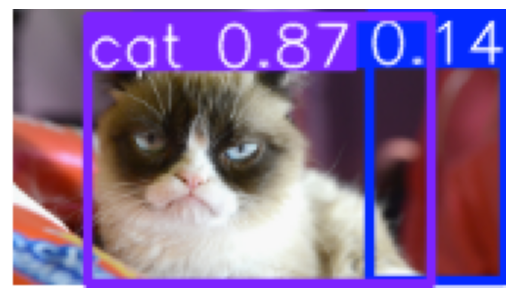


image 1/1 /home/hunt3041/PikaVision/test_images/the_dog.png: 416x640 1 dog, 37.1ms
Speed: 1.0ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


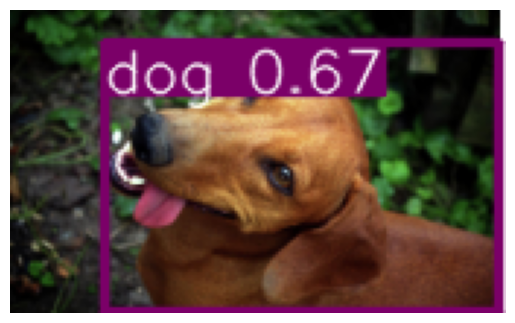


image 1/1 /home/hunt3041/PikaVision/test_images/the_drone.jpg: 384x640 1 airplane, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


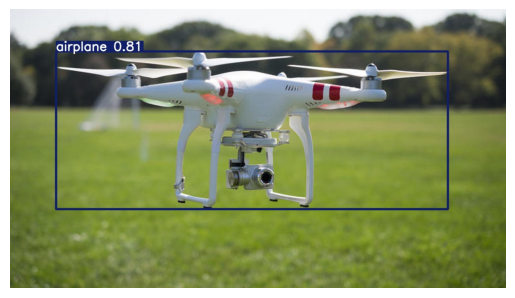


image 1/1 /home/hunt3041/PikaVision/test_images/the_person.png: 448x640 2 persons, 48.9ms
Speed: 0.9ms preprocess, 48.9ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)


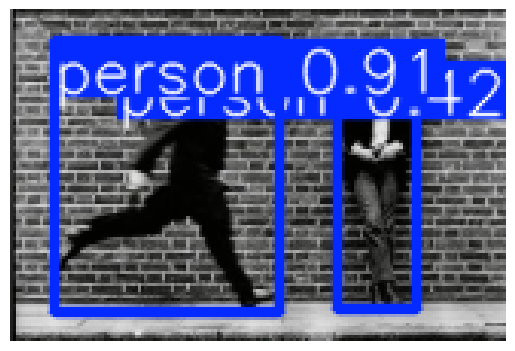


image 1/1 /home/hunt3041/PikaVision/test_images/the_pikachu.jpeg: 320x640 2 teddy bears, 32.9ms
Speed: 0.7ms preprocess, 32.9ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


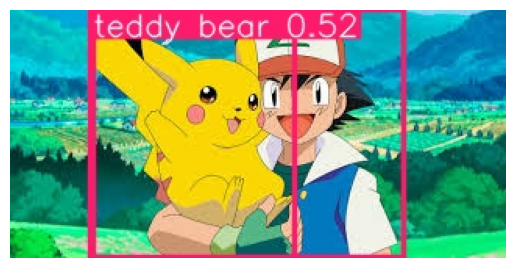

In [11]:
# Test the pretrained model
test_model(model, 'the_cat.png')
test_model(model, 'the_dog.png')
test_model(model, 'the_drone.jpg')
test_model(model, 'the_person.png')
test_model(model, 'the_pikachu.jpeg') 

In [12]:
train_model(model, 'data.yaml')

Ultralytics 8.3.43 🚀 Python-3.8.10 torch-2.4.1+cu121 CUDA:gpu (NVIDIA GeForce RTX 3060, 12288MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/hunt3041/PikaVision/project2-dataset-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=gpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

100%|██████████| 755k/755k [00:00<00:00, 7.61MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 319 layers, 2,590,815 parameters, 2,590,799 gradients, 6.4 GFLOPs

Transferred 79/499 items from pretrained weights


KeyboardInterrupt: 

In [ ]:
best_model = YOLO(path_to('runs', 'detect', '5_categories_no_aug', 'weights', 'best.pt'))
test_model(best_model, 'the_cat.png')
test_model(best_model, 'the_dog.png')
test_model(best_model, 'the_drone.jpg')
test_model(best_model, 'the_person.png')
test_model(best_model, 'the_pikachu.jpeg')
test_model(best_model, 'dog2.jpg')
test_model(best_model, 'person2.jpg')

In [6]:
# Load custom model
new_model = YOLO(path_to('runs', 'detect', '5_categories_no_aug', 'weights', 'best.pt'))

In [ ]:
# test custom model
test_model(new_model, 'the_cat.png')
test_model(new_model, 'the_dog.png')
test_model(new_model, 'the_drone.jpg')
test_model(new_model, 'the_person.png')
test_model(new_model, 'the_pikachu.jpeg')
test_model(new_model, 'dog2.jpg')
test_model(new_model, 'person2.jpg')

In [11]:
test_model_video(new_model, 'pika.mp4')
test_model_video(new_model, 'drone.mp4')
test_model_video(new_model, 'dog_cat.mp4')


0: 384x640 3 persons, 48.5ms
Speed: 1.6ms preprocess, 48.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 43.9ms
Speed: 1.6ms preprocess, 43.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 3 persons, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 2 persons, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 3 persons, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 4 persons, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.

In [14]:
results = new_model.val(data=path_to('project2-dataset-5', 'data.yaml'))

Ultralytics 8.3.34 🚀 Python-3.8.10 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)


val: Scanning /home/hunt3041/PikaVision/project2-dataset-5/valid/labels.cache... 1946 images, 241 backgrounds, 0 corrupt: 100%|██████████| 1946/1946 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:12<00:00,  9.64it/s]


                   all       1946       2115      0.969      0.925      0.968      0.817
                   cat        254        257      0.991      0.992      0.994      0.929
                   dog        495        495      0.988      0.986      0.994      0.862
                 drone        469        499      0.976      0.971      0.991      0.707
                person        357        728      0.932      0.758      0.895      0.742
               pikachu        130        136      0.958      0.919      0.967      0.847
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


Function Used for Live Detection

In [7]:
def live_detection(model: YOLO):
    """
    Capture live video feed from the laptop camera and use YOLO model for object detection.
    
    Parameters:
        model (YOLO): The YOLO model that you want to use for live detection.
        
    Returns:
        None: Displays the live feed with detected objects.
    """
    # Start video capture (0 is the default camera on most systems)
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Camera not found.")
        return
    
    print("Press 'q' to quit.")
    
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Failed to capture image.")
            break
        
        # Convert the frame to RGB for YOLO model compatibility
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert the frame to a PIL image for YOLO
        pil_image = Image.fromarray(rgb_frame)
        
        # Perform inference with the YOLO model
        results = model(pil_image)
        
        # Draw the results on the frame
        annotated_frame = results[0].plot()  # Annotated image with detected objects
        
        # Display the annotated frame
        cv2.imshow("YOLO Live Detection", annotated_frame)
        
        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release the camera and close the window
    cap.release()
    cv2.destroyAllWindows()

Test the Live Detection

In [9]:
live_detection(new_model)

Press 'q' to quit.

0: 480x640 1 person, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 46.0ms
Speed: 0.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 45.0ms
Speed: 0.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image